# Iris flower classifier (server version)

In [5]:
# Using Python 3.10 inside a Conda Environment
import warnings
warnings.filterwarnings('ignore')

In [6]:
# SciPy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Utilities
import os
import pickle
import requests as req
from io import BytesIO
import boto3

# MachineLearning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import _dist_metrics #ira?
from keras.utils import to_categorical


# DeepLearning
import keras
from keras import models
from keras import layers

# Main modules
import predictions as pr
import aws_utils as au

In [7]:
REGION = 'us-east-1'
BUCKET_NAME = 'mma-models-in-production' # Unique through all accounts
FOLDER = 'dist' # Should be clean before the execution

## Exploración de la data

In [8]:
iris = sns.load_dataset('iris')

In [9]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [10]:
iris.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
130,7.4,2.8,6.1,1.9,virginica
39,5.1,3.4,1.5,0.2,setosa
99,5.7,2.8,4.1,1.3,versicolor
105,7.6,3.0,6.6,2.1,virginica
42,4.4,3.2,1.3,0.2,setosa


¿Que tenemos que hacer con este dataset?

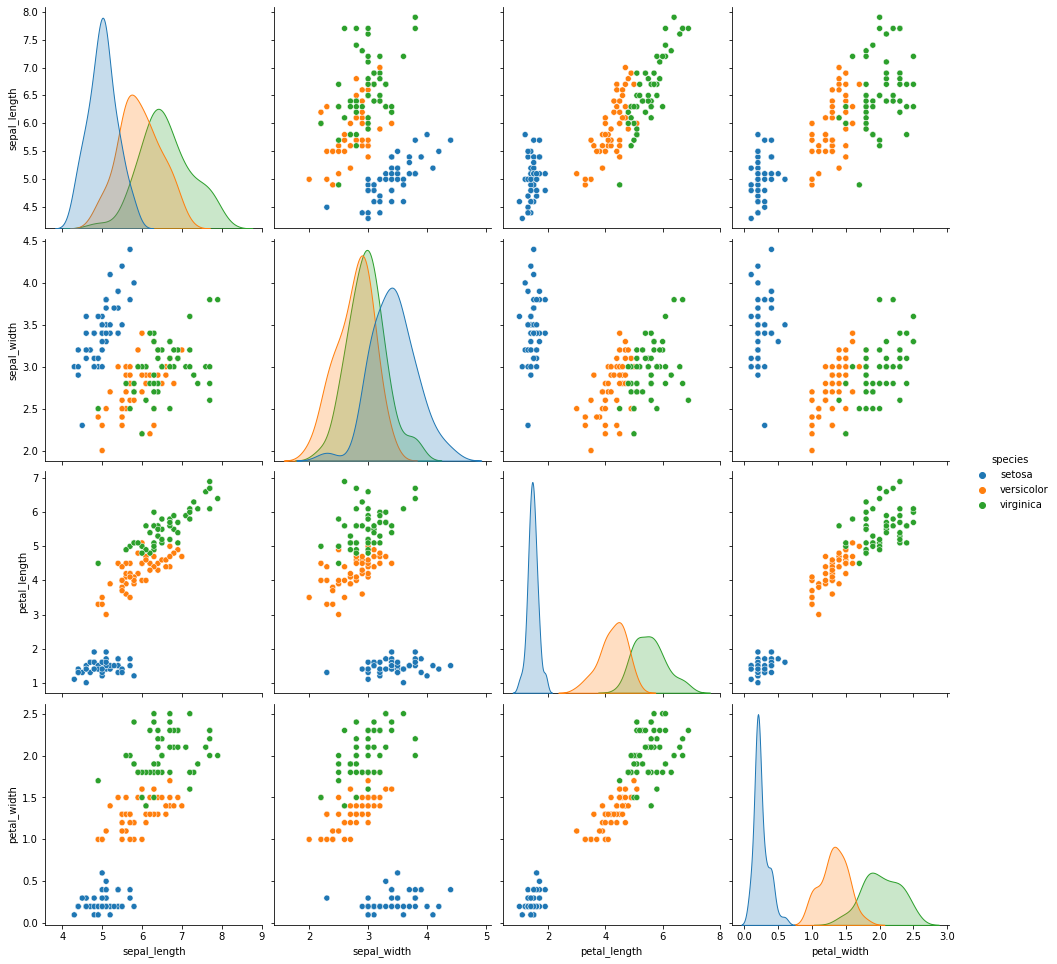

In [11]:
sns.pairplot(iris, hue='species', size=3.4);

## Primer modelo

In [12]:
def fit_normalizer(input_data: pd.DataFrame) -> StandardScaler:
    """
        Fit a scikit-learn Normalizer based on input_data.
    """    
    scaler = StandardScaler()
    print('Fitting a Normalizer with given input')    
    scaler.fit(input_data)
    
    file_name = 'normalizer.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(scaler, f)
    
    # TODO Part 2
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        
    
    print('Normalizer saved')
    return scaler

In [13]:
normalizer = fit_normalizer(iris.drop("species", axis=1))

Fitting a Normalizer with given input
Normalizer saved


In [14]:
X = normalizer.transform(iris.drop("species", axis=1))

In [15]:
def fit_encoder(target_list: list) -> LabelEncoder:
    """
        Fit a scikit-learn LabelEncoder based on target_list.
    """    
    encoder = LabelEncoder()
    print('Fitting a LabelEncoder with given target')
    encoder.fit(target_list)
    
    print('Found classes', encoder.classes_)
    print('Testing encoder', encoder.transform(encoder.classes_))
    
    file_name = 'encoder.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(encoder, f)

    # TODO Part 2        
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        
    
    print('Encoder saved')
    return encoder

In [16]:
# All the target column
target_list = iris['species'].tolist()
encoder = fit_encoder(target_list)

Fitting a LabelEncoder with given target
Found classes ['setosa' 'versicolor' 'virginica']
Testing encoder [0 1 2]
Encoder saved


In [17]:
def encode_and_one_hot_target(target_list: list, encoder: LabelEncoder) -> np.ndarray:
    print('Encoding target with given encoder')
    targets_encoded = encoder.transform(target_list)

    print('Convert encoded classes integers to dummy variables')
    targets_one_hot = to_categorical(targets_encoded)
    
    print('Target final shape', targets_one_hot.shape)
    return targets_one_hot

In [18]:
Y = encode_and_one_hot_target(target_list, encoder)

Encoding target with given encoder
Convert encoded classes integers to dummy variables
Target final shape (150, 3)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1, test_size = .33)

In [20]:
X_train.shape

(100, 4)

In [21]:
X_test.shape

(50, 4)

In [22]:
y_train.shape

(100, 3)

In [23]:
y_test.shape

(50, 3)

In [24]:
def fit_knn(X_train: np.ndarray, y_train: np.ndarray) -> KNeighborsClassifier:
    """
        Fits a KNN model, saves the model weights and returns it.
    """
    # Instantiate the model learning model (k=3)
    knn = KNeighborsClassifier(n_neighbors=3)
    
    # Fitting the model
    print('Fitting model')
    model = knn.fit(X_train, y_train)
    
    file_name = 'model.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(model, f)
      
    # TODO Part 2    
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)        

    print('Model saved')
    return model

In [25]:
model = fit_knn(X_train, y_train)

Fitting model
Model saved


In [26]:
Y_pred = model.predict(X_test)

In [27]:
accuracy_score(y_test, Y_pred)

0.98

## Código para el servido

- Todos los componentes del modelo exportado en la carpeta `dist`: `encoder.pkl`, `model.pkl` y `normalizer.pkl`
- Inspeccionemos el código de `predictions.predict()`

In [28]:
# From package
versicolor = [6.3, 2.5, 4.9, 1.5]
virginica = [7.9, 3.8, 6.4, 2.0]
pr.predict(versicolor)

Fetching binaries
Loading normalizer.pkl from local
Loading encoder.pkl from local
Loading model.pkl from local
Received sample: [6.3, 2.5, 4.9, 1.5]
After normalization: [[ 0.55333328 -1.28296331  0.64908342  0.3957741 ]]
y_probabilities: [[0. 1. 0.]]
y_class: [1]
y_class_decoded: ['versicolor']


{'sample': [6.3, 2.5, 4.9, 1.5], 'class': 'versicolor', 'confidence': 100.0}

- Inspeccionemos el código de `app.classify()`

```bash
# Terminal
conda activate python-3.10
# Run Flask locally
python app.py
```

In [ ]:
!python app.py

In [30]:
# Browser with Public DNS.
req.get('http://localhost:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

{'class': 'setosa',
 'confidence': 100.0,
 'sample': ['5.1', '3.5', '1.4', '0.2']}

- ¿Que vemos en el log del server?

##### En el enviroment con python 3.10 y scikit-learn 1.3.0 no funcionó muestra  "ModuleNotFoundError: No module named  'sklearn.neighbors._dist_metrics'" 

Lo corri en el enviroment base con Python 3.9.7 y scikit-learn 0.24.2

## Packaging & Deploy

- Exportar todas las dependencias utilizadas a un archivo `requirements.txt` (con versión)  
- Armar y probar la aplicación en un virtual environment
- ¿Que es un virtual environment? Permite empaquetar el ejecutable de python y los módulos instalados.
- Todo esto prepara la aplicación para correr en la nube.

```bash
# Terminal
# Install virtual environments package with pip
pip install virtualenv

# Create virtual environment with new python executable
virtualenv env --python=python3.10

# Activate it, prompt changes
source env/bin/activate
# In Windows, primero cambiar al path de la carpeta env
Scripts\activate

# Install all dependencies in requirements.txt
pip install -r requirements.txt

# Test the app inside virtual environment, stop the above execution in terminal, show the log
python app.py

# Zip the app, without virtual environment, what are we omitting?
zip -r models-in-production.zip app.py predictions.py aws_utils.py config.py requirements.txt dist

#In Windows
"C:\Program Files\7-Zip\7z.exe" a -tzip models-in-production.zip app.py predictions.py aws_utils.py config.py requirements2.txt

```

## Instancia de AWS
- En AWS Academy, ir a la derecha en "AWS details" / "Cloud Access" / "AWS CLI" / "Show"
- Bajar tambien el SSH key y pegarlo en la carpera `.ssh` con permisos `400`
- Instanciar una t2.micro con Ubuntu 22.04, SSH habilitado y la clave rsa que nos sugiere
- Mientras se aprovisiona habilitar el puerto 5000 en el security group
- Conectarse con su DNS público

```bash
# Cloud: Connect to instance
ssh -i ~/.ssh/vockey.pem ubuntu@ec2-3-91-238-157.compute-1.amazonaws.com
ssh -i ~/.ssh/vockey.pem ubuntu@ec2-54-198-226-151.compute-1.amazonaws.com

# Cloud: Install python 3.10, pip. virtualenv and unzip
sudo add-apt-repository ppa:deadsnakes/ppa && sudo apt-get update && sudo apt-get install -y unzip python3.10 python3-pip virtualenv

# A little shorcut
alias python=python3

# Local: Upload the packaged app
scp -i ~/.ssh/vockey.pem models-in-production.zip ubuntu@ec2-3-91-238-157.compute-1.amazonaws.com:/home/ubuntu
scp -i ~/.ssh/vockey.pem models-in-production.zip ubuntu@ec2-3-91-238-157.compute-1.amazonaws.com:/home/ubuntu


# Cloud
unzip -o models-in-production.zip

# Cloud, same steps as local
virtualenv env --python=python3.10
source env/bin/activate
pip install -r requirements.txt --no-cache-dir
python app.py
```

```bash
# Extra
# nohup means: do not terminate this process even when the stty is cut off.
# & at the end means: run this command as a background task
nohup python app.py &
ps -ef | grep app.py
# https://stackoverflow.com/questions/17385794/how-to-get-the-process-id-to-kill-a-nohup-process
# https://stackoverflow.com/questions/23029443/run-python-flask-on-ec2-in-the-backgroud

# If you lost your SSH connection, connect again and kill the old process
fuser -k 5000/tcp
```

In [ ]:
# Browser with Public DNS.
req.get('http://ec2-3-91-238-157.compute-1.amazonaws.com:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

## Modelo dinámico

¿Que es más probable que cambie, el modelo o la API?

- Crear un bucket para los modelos `mma-models-in-production`
- Subir los tres componentes del modelo con la Consola
- Mostrar `aws_utils.py`
- Configurar `YOUR_AWS_ACCESS_KEY_ID`, `YOUR_AWS_SECRET_ACCESS_KEY` y el nombre del bucket en `config.py`
- Cambiar el nombre del bucket en la variable de entorno de esta misma notebook
- Descomentar `TODO Part 2` en `predictions.fetch_pickle()`
- Borrar `models-in-production.zip` y el contenido de la carpeta `dist`

```bash
# Cloud: Stop service in instance

# Local: Zip the new app
zip -r models-in-production.zip app.py predictions.py aws_utils.py config.py requirements.txt dist

# Local: Upload the new packaged app
scp -i ~/.ssh/vockey.pem models-in-production.zip ubuntu@ec2-3-91-238-157.compute-1.amazonaws.com:/home/ubuntu

# Cloud:
unzip -o models-in-production.zip

# Cloud, restart service
python app.py
```

In [ ]:
# Browser with Public DNS.
req.get('http://ec2-3-91-238-157.compute-1.amazonaws.com:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

## Segundo modelo

In [ ]:
def fit_random_forest(X_train, y_train):
    """
        Fits a Random Forest model, saves the model weights, uploads to S3 and return it.
    """    
    rfc = RandomForestClassifier(n_jobs=-1, criterion = 'entropy', random_state = 0, max_features= 'sqrt')  

    param_grid = {  
               "n_estimators" : [5, 8, 10],  
               "max_depth" : [4, 5, 6],  
               "min_samples_leaf" : [8, 10, 12]}  

    CV_rf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
    
    CV_rf.fit(X_train, y_train)    
    print(f'best_params: {CV_rf.best_params_}')
    
    file_name = 'model.pkl'
    with open(os.path.join(FOLDER, file_name), 'wb') as f:
        pickle.dump(model, f)
    
    # TODO Part 2, uncomment all TODO Part 2 above in fit_normalizer() and fit_encoder() and run
    # au.upload_to_s3(BUCKET_NAME, FOLDER, file_name)   
    
    return CV_rf

In [ ]:
model = fit_random_forest(X_train, y_train)

- ¿Se subio a S3? Veamos en la consola

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, Y_pred)

In [ ]:
# Browser with Public DNS.
req.get('http://ec2-3-91-238-157.compute-1.amazonaws.com:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

## Tercer Modelo

In [ ]:
x_train, x_test, Y_train, Y_test = train_test_split(X, Y, random_state=1, test_size = .33)

In [ ]:
def print_figure(training_values, validation_values, metric):
    epochs = range(1, len(training_values) + 1)
    
    plt.clf()
    plt.plot(epochs, training_values, 'bo', label='Training ' + metric) # bo es blue dot
    plt.plot(epochs, validation_values, 'b', label='Validation ' + metric)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

    plt.show()   

In [ ]:
def print_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    print_figure(loss_values, val_loss_values, 'Loss')

In [ ]:
def print_acc(history):
    history_dict = history.history
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    
    print_figure(acc_values, val_acc_values, 'Accuracy')

In [ ]:
# Simple Neural Network
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(4,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
x_val = x_train[:50]
partial_x_train = x_train[50:]

y_val = Y_train[:50]
partial_y_train = Y_train[50:]

In [ ]:
partial_x_train.shape

In [ ]:
partial_y_train.shape

In [ ]:
%time history = model.fit(partial_x_train, partial_y_train, epochs=30, batch_size=10, validation_data=(x_val, y_val))

In [ ]:
# Serialize model to JSON
file_name = 'model.json'
model_json = model.to_json()

In [ ]:
# Network architecture
model_json

In [ ]:
with open(os.path.join(FOLDER, file_name), "w") as json_file:
    json_file.write(model_json)
au.upload_to_s3(BUCKET_NAME, FOLDER, file_name) 
print("Saved model definition to disk")

In [ ]:
# Serialize weights to HDF5
file_name = 'model.h5'
model.save_weights(os.path.join(FOLDER, file_name))
au.upload_to_s3(BUCKET_NAME, FOLDER, file_name) 
print("Saved model weights to disk")

- ¿Se subio a S3? Veamos en la consola

In [ ]:
print_loss(history)

In [ ]:
print_acc(history)

- Descomentar `TODO Part 3` en `predictions.predict()`
- Relanzar local la API

In [ ]:
# Browser
req.get('http://localhost:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

```bash
# Stop service in instance

# Local: Zip the new app
zip -r models-in-production.zip app.py predictions.py aws_utils.py config.py requirements.txt dist

# Local: Upload the new packaged app
scp -i ~/.ssh/vockey.pem models-in-production.zip ubuntu@ec2-3-91-238-157.compute-1.amazonaws.com:/home/ubuntu

# Cloud
unzip -o models-in-production.zip

# Cloud: restart service
python app.py
```

In [ ]:
# Browser with Public DNS.
req.get('http://ec2-3-91-238-157.compute-1.amazonaws.com:5000/classify?sepal_length=5.1&sepal_width=3.5&petal_length=1.4&petal_width=0.2').json()

## Limpieza
- Terminar la instancia creada.
- Borrar el bucket creado.
- Borrar las `AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY` y `AWS_SESSION_TOKEN`de `config.py`
- Volver a comentar `# TODO Part 2` y `# TODO Part 3`